# Analysis of the Datasets based on the heuristic we defined

In [10]:
import numpy as np
import cv2
import torch
from torchvision import datasets, transforms
from sklearn.neighbors import NearestNeighbors
from skimage.feature import hog
from scipy.stats import entropy
from typing import List, Tuple, Dict, Optional
from functools import lru_cache
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd
from collections import defaultdict
import warnings
import ipywidgets

warnings.filterwarnings('ignore')

## Dataset configs


In [11]:


DATASET_CONFIGS = {
    'fashion_mnist': {
        'image_size': (28, 28),
        'channels': 1,
        'hog_params': {
            'pixels_per_cell': (8, 8),
            'cells_per_block': (2, 2),
        },
        'gabor_params': {
            'frequencies': [0.1, 0.2, 0.3],
            'orientations': [0, np.pi/4, np.pi/2, 3*np.pi/4],
            'kernel_size': 21,
        },
        'default_weights': [0.2, 0.1, 0.2, 0.2, 0.1, 0.2],
        'color_mode': 'grayscale'
    },
    'cifar10': {
        'image_size': (32, 32),
        'channels': 3,
        'hog_params': {
            'pixels_per_cell': (4, 4),
            'cells_per_block': (2, 2),
        },
        'gabor_params': {
            'frequencies': [0.1, 0.2, 0.3, 0.4],
            'orientations': [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8],
            'kernel_size': 31,
        },
        'default_weights': [0.2, 0.3, 0.1, 0.2, 0.1, 0.1],
        'color_mode': 'rgb'
    },
    'cifar100': {
        'image_size': (32, 32),
        'channels': 3,
        'hog_params': {
            'pixels_per_cell': (4, 4),
            'cells_per_block': (2, 2),
        },
        'gabor_params': {
            'frequencies': [0.1, 0.2, 0.3, 0.4],
            'orientations': [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, 5*np.pi/8, 3*np.pi/4, 7*np.pi/8],
            'kernel_size': 31,
        },
        'default_weights': [0.2, 0.3, 0.1, 0.2, 0.1, 0.1],
        'color_mode': 'rgb'
    }
}

## Helper functions

In [12]:


@lru_cache(maxsize=256)
def get_gabor_kernel_cached(kernel_size, sigma, theta, lambd, gamma):
    """Cache de kernels Gabor para evitar cálculos repetidos"""
    return cv2.getGaborKernel(
        (kernel_size, kernel_size), sigma, theta, lambd, gamma, 0.0, ktype=cv2.CV_32F
    )

def my_gabor_filter_optimized(img, frequency, theta, kernel_size=31, sigma=1.0, gamma=1.0):
    """Versión optimizada del filtro Gabor con kernel cacheado"""
    lambd = 1.0 / frequency
    gabor_kernel = get_gabor_kernel_cached(kernel_size, sigma, theta, lambd, gamma)

    if len(img.shape) == 3 and img.shape[2] == 3:
        filtered_channels = []
        for channel in range(3):
            filtered_channel = cv2.filter2D(img[:, :, channel], cv2.CV_32F, gabor_kernel)
            filtered_channels.append(filtered_channel)
        filtered_img = np.stack(filtered_channels, axis=2)
    else:
        filtered_img = cv2.filter2D(img, cv2.CV_32F, gabor_kernel)

    return filtered_img

def compute_knn_distances_batch(embeddings: np.ndarray, k: int = 5) -> np.ndarray:
    """
    Computa distancias KNN para todos los embeddings de una vez
    """
    n_samples = embeddings.shape[0]

    if len(embeddings.shape) == 1:
        embeddings = embeddings.reshape(1, -1)
    elif len(embeddings.shape) > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)

    knn = NearestNeighbors(n_neighbors=min(k + 1, n_samples),
                          algorithm='auto',
                          metric='euclidean')
    knn.fit(embeddings)

    distances, _ = knn.kneighbors(embeddings)
    knn_distances = np.mean(distances[:, 1:k+1], axis=1)

    return knn_distances


def compute_knn_purity_batch(embeddings: np.ndarray, labels: np.ndarray, k: int = 5) -> np.ndarray:
    n_samples = embeddings.shape[0]

    # Asegurar formato correcto
    if len(embeddings.shape) == 1:
        embeddings = embeddings.reshape(1, -1)
    elif len(embeddings.shape) > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)

    # Crear y ajustar modelo KNN
    knn = NearestNeighbors(n_neighbors=min(k + 1, n_samples),
                          algorithm='auto',
                          metric='euclidean')
    knn.fit(embeddings)

    # Encontrar vecinos más cercanos
    distances, indices = knn.kneighbors(embeddings)

    # Calcular pureza para cada muestra
    purities = []
    for i in range(n_samples):
        # Excluir el punto mismo (primer vecino)
        neighbor_indices = indices[i, 1:k+1]
        neighbor_labels = labels[neighbor_indices]

        # Contar cuántos vecinos tienen la misma etiqueta
        same_class_count = np.sum(neighbor_labels == labels[i])
        purity = same_class_count / k

        purities.append(purity)

    return np.array(purities)

In [13]:


class DifficultyScorer:
    """Clase para calcular scores de dificultad de forma optimizada"""

    def __init__(self, dataset_name: str = 'fashion_mnist', use_color_hog: bool = None):
        """
        Inicializa el scorer para un dataset específico.

        Args:
            dataset_name: 'fashion_mnist', 'cifar10' o 'cifar100'
            use_color_hog: Si es True, usa HOG en color (solo para datasets RGB).
        """
        self.dataset_name = dataset_name
        self.config = DATASET_CONFIGS[dataset_name].copy()

        # Configuración específica
        self.frequencies = self.config['gabor_params']['frequencies']
        self.orientations = self.config['gabor_params']['orientations']
        self.kernel_size = self.config['gabor_params']['kernel_size']
        self.hog_params = self.config['hog_params']
        self.color_mode = self.config['color_mode']

        # Para datasets RGB, decidir si usar HOG en color
        if self.color_mode == 'rgb':
            if use_color_hog is not None:
                self.use_color_hog = use_color_hog
            else:
                self.use_color_hog = False
        else:
            self.use_color_hog = False

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Caches
        self.hog_embeddings_cache = None
        self.centroids_por_clase = {}  # CAMBIO: centroides por clase, no uno general
        self.knn_purity_cache = None  # CAMBIO: pureza KNN en lugar de distancia
        self.gabor_features_cache = {}
        self.color_features_cache = {}

        # Definir nombres y descripciones de características
        self.feature_names = [
            'dist_centroid', 'color_dist', 'knn_difficulty',
            'gabor_energy', 'gabor_entropy', 'gabor_contrast'
        ]

        self.feature_descriptions = [
            'Distance to the HOG centroid of its class',
            'Color distinctiveness',
            'KNN purity',
            'Energy from the Gabor filters',
            'Entropy based on Gabor filters',
            'Contrast of the Gabor filters'
        ]

        print(f"Scorer initialized for {dataset_name}")
        print(f"  - Color mode: {self.color_mode}")
        print(f"  - Use color HOG: {self.use_color_hog}")
        print(f"  - DEevice: {self.device}")

    def _compute_hog_embedding(self, img: np.ndarray) -> np.ndarray:
        """Calcula el embedding HOG, adaptado al tipo de imagen"""
        # Para imágenes en escala de grises
        if self.color_mode == 'grayscale':
            return hog(img,
                      pixels_per_cell=self.hog_params['pixels_per_cell'],
                      cells_per_block=self.hog_params['cells_per_block'],
                      visualize=False,
                      feature_vector=True)

        # Para imágenes RGB
        elif self.color_mode == 'rgb':
            if self.use_color_hog:
                # HOG en color (3 canales)
                hog_features = []
                for channel in range(3):
                    channel_features = hog(img[:, :, channel],
                                          pixels_per_cell=self.hog_params['pixels_per_cell'],
                                          cells_per_block=self.hog_params['cells_per_block'],
                                          visualize=False,
                                          feature_vector=True)
                    hog_features.append(channel_features)
                return np.concatenate(hog_features)
            else:
                # Convertir a escala de grises para HOG
                if len(img.shape) == 3 and img.shape[2] == 3:
                    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
                else:
                    img_gray = img

                return hog(img_gray,
                          pixels_per_cell=self.hog_params['pixels_per_cell'],
                          cells_per_block=self.hog_params['cells_per_block'],
                          visualize=False,
                          feature_vector=True)
        else:
            raise ValueError(f"Color mode no soportado: {self.color_mode}")

    def _compute_gabor_features(self, img: np.ndarray):
        """Computa características Gabor para una imagen"""
        total_energy = 0.0
        entropy_values = []
        contrast_values = []

        # Para imágenes a color, convertimos a escala de grises para Gabor
        if len(img.shape) == 3 and img.shape[2] == 3:
            img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
        else:
            img_gray = img

        for frequency in self.frequencies:
            for theta in self.orientations:
                filtered_img = my_gabor_filter_optimized(
                    img_gray, frequency, theta, kernel_size=self.kernel_size
                )

                # Energía
                total_energy += np.sum(filtered_img ** 2)

                # Entropía
                hist, _ = np.histogram(filtered_img.flatten(), bins=50,
                                       range=(filtered_img.min(), filtered_img.max()))
                if hist.sum() > 0:
                    hist_norm = hist / hist.sum()
                    entropy_values.append(entropy(hist_norm))

                # Contraste (varianza)
                contrast_values.append(np.var(filtered_img))

        gabor_entropy = np.mean(entropy_values) if entropy_values else 0.0
        gabor_contrast = np.mean(contrast_values) if contrast_values else 0.0

        return total_energy, gabor_entropy, gabor_contrast

    def _compute_color_distinctiveness(self, img: np.ndarray) -> float:
        """Calcula la distintividad de color"""
        if len(img.shape) == 2 or img.shape[2] == 1:
            # Para imágenes en escala de grises
            hist, _ = np.histogram(img.flatten(), bins=50)
        else:
            # Para imágenes RGB
            img_uint8 = (img * 255).astype(np.uint8)

            # Convertir a HSV para análisis de color
            hsv_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2HSV)

            # Calcular histograma en el canal H (tono)
            hist = cv2.calcHist([hsv_img], [0], None, [180], [0, 180])
            hist = hist.flatten()

        if hist.sum() > 0:
            hist_norm = hist / hist.sum()
            return entropy(hist_norm)
        return 0.0

    def _normalize_features_batch(self, features_tensor: torch.Tensor) -> torch.Tensor:
        """Normalización por características (columnas)"""
        mean = torch.mean(features_tensor, dim=0, keepdim=True)
        std = torch.std(features_tensor, dim=0, keepdim=True) + 1e-8  # Añadir epsilon para estabilidad
        return (features_tensor - mean) / std

    def precompute_all_features(self, images: List[np.ndarray], labels: List[int]) -> Tuple[torch.Tensor, dict]:
        """
        Precomputa todas las características necesarias

        Args:
            images: Lista de imágenes
            labels: Lista de etiquetas (necesario para pureza KNN y centroides por clase)

        Returns:
            (características normalizadas, metadatos)
        """
        print(f"Computing features for {len(images)} imágenes...")

        # Convertir labels a numpy array
        labels_array = np.array(labels)

        # Precomputar embeddings HOG
        self.hog_embeddings_cache = []
        for img in tqdm(images, desc="Computing HOG"):
            self.hog_embeddings_cache.append(self._compute_hog_embedding(img))
        self.hog_embeddings_cache = np.array(self.hog_embeddings_cache)

        # CALCULAR CENTROIDES POR CLASE (NO centroide general)
        print("Computing class's centroids...")
        unique_classes = np.unique(labels_array)
        self.centroids_por_clase = {}

        for class_id in tqdm(unique_classes, desc="Processing classes"):
            class_indices = np.where(labels_array == class_id)[0]
            if len(class_indices) > 0:
                class_embeddings = self.hog_embeddings_cache[class_indices]
                self.centroids_por_clase[class_id] = np.mean(class_embeddings, axis=0)

        # Calcular pureza KNN (REEMPLAZA distancia KNN)
        print("Computing KNN purity...")
        self.knn_purity_cache = compute_knn_purity_batch(
            self.hog_embeddings_cache, labels_array, k=5
        )

        # Calcular características por imagen
        all_features = []

        for idx, img in enumerate(tqdm(images, desc="Computing features")):
            # Usar embeddings HOG precomputados
            hog_embedding = self.hog_embeddings_cache[idx]
            label = labels[idx]

            # 1. DISTANCIA AL CENTROIDE DE SU CLASE
            if label in self.centroids_por_clase:
                class_centroid = self.centroids_por_clase[label]
                dist_centroid = np.linalg.norm(hog_embedding - class_centroid)
            else:
                # Fallback si la clase no está en centroides (no debería pasar)
                dist_centroid = 0.0

            # 2. DIFICULTAD KNN (1 - pureza)
            knn_purity = self.knn_purity_cache[idx]
            knn_difficulty = 1.0 - knn_purity

            # 3. Características Gabor (cacheadas por imagen)
            if idx not in self.gabor_features_cache:
                gabor_energy, gabor_entropy, gabor_contrast = self._compute_gabor_features(img)
                self.gabor_features_cache[idx] = (gabor_energy, gabor_entropy, gabor_contrast)

            gabor_energy, gabor_entropy, gabor_contrast = self.gabor_features_cache[idx]

            # 4. Distinctividad de color
            if idx not in self.color_features_cache:
                self.color_features_cache[idx] = self._compute_color_distinctiveness(img)

            color_dist = self.color_features_cache[idx]

            # Combinar características
            features = np.array([
                dist_centroid,
                color_dist,
                knn_difficulty,
                gabor_energy,
                gabor_entropy,
                gabor_contrast
            ], dtype=np.float32)

            all_features.append(features)

        # Convertir a tensor y normalizar
        features_tensor = torch.tensor(np.array(all_features), dtype=torch.float32).to(self.device)
        features_normalized = self._normalize_features_batch(features_tensor)

        # Metadatos para referencia
        metadata = {
            'hog_embeddings': self.hog_embeddings_cache,
            'centroids_por_clase': self.centroids_por_clase,  # CAMBIO: diccionario de centroides
            'knn_purities': self.knn_purity_cache,
            'knn_difficulties': 1.0 - self.knn_purity_cache,
            'feature_names': self.feature_names,
            'feature_descriptions': self.feature_descriptions,
            'device': str(self.device),
            'dataset_name': self.dataset_name,
            'use_color_hog': self.use_color_hog,
            'n_features': features_tensor.shape[1],
            'n_images': len(images),
            'n_classes': len(unique_classes),
            'labels': labels
        }

        return features_normalized, metadata

    def compute_difficulty_scores(self,
                                 features_normalized: torch.Tensor,
                                 weights: Optional[torch.Tensor] = None) -> torch.Tensor:

        if features_normalized.device != self.device:
            features_normalized = features_normalized.to(self.device)

        if weights is None:
            default_weights = self.config.get('default_weights', [1.0] * features_normalized.shape[1])
            weights = torch.tensor(default_weights, dtype=torch.float32, device=self.device)
        else:
            if isinstance(weights, (list, np.ndarray)):
                weights = torch.tensor(weights, dtype=torch.float32)

            if weights.device != self.device:
                weights = weights.to(self.device)

        # Calcular score como combinación ponderada
        scores = torch.sum(features_normalized * weights, dim=1)

        # Normalizar scores a [0, 1]
        min_score = torch.min(scores)
        max_score = torch.max(scores)
        if (max_score - min_score) > 1e-8:
            scores_normalized = (scores - min_score) / (max_score - min_score)
        else:
            scores_normalized = torch.zeros_like(scores)

        return scores_normalized


    def get_features_for_image(self, img_idx: int, features_normalized: torch.Tensor) -> Dict[str, float]:

        feature_names = self.feature_names

        normalized_features = features_normalized[img_idx].cpu().numpy()
        features_dict = {name: float(value) for name, value in zip(feature_names, normalized_features)}

        return features_dict

    def get_class_centroid_distance(self, img_idx: int, labels: List[int]) -> float:

        label = labels[img_idx]

        hog_embedding = self.hog_embeddings_cache[img_idx]
        class_centroid = self.centroids_por_clase[label]

        return float(np.linalg.norm(hog_embedding - class_centroid))

    def get_knn_purity(self, img_idx: int) -> float:

        return float(self.knn_purity_cache[img_idx])

print("Clase DifficultyScorer definida (con centroides por clase y pureza KNN)")

Clase DifficultyScorer definida (con centroides por clase y pureza KNN)


In [14]:
class DatasetLoader:
    """Clase para cargar y preprocesar datasets"""

    @staticmethod
    def load_fashion_mnist(classes=None, n_samples=None, train=True, transform=None):
        """Carga FashionMNIST"""
        if transform is None:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

        dataset = datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform)
        return DatasetLoader._process_dataset(dataset, classes, n_samples, 'grayscale')

    @staticmethod
    def load_cifar10(classes=None, n_samples=None, train=True, transform=None):
        """Carga CIFAR-10"""
        if transform is None:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
            ])

        dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
        return DatasetLoader._process_dataset(dataset, classes, n_samples, 'rgb')

    @staticmethod
    def load_cifar100(classes=None, n_samples=None, train=True, transform=None):
        """Carga CIFAR-100"""
        if transform is None:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])

        dataset = datasets.CIFAR100(root='./data', train=train, download=True, transform=transform)
        return DatasetLoader._process_dataset(dataset, classes, n_samples, 'rgb')

    @staticmethod
    def _process_dataset(dataset, classes, n_samples, color_mode):
        """Procesa el dataset cargado"""
        if classes is None:
            classes = list(range(max(10, len(dataset.classes))))

        # Filtrar por clases
        selected_indices = [i for i, (_, label) in enumerate(dataset) if label in classes]

        # Limitar muestras
        if n_samples is not None:
            selected_indices = selected_indices[:n_samples]

        selected_data = torch.utils.data.Subset(dataset, selected_indices)

        # Convertir a arrays
        images = []
        labels = []
        for data in selected_data:
            img_tensor, label = data

            if color_mode == 'grayscale':
                img_np = img_tensor.numpy().squeeze()  # [H, W]
            else:  # rgb
                img_np = img_tensor.numpy().transpose(1, 2, 0)  # [H, W, C]

            images.append(img_np)
            labels.append(label)

        return images, labels, selected_indices

    @staticmethod
    def load_dataset(dataset_name, **kwargs):
        """Carga cualquier dataset soportado"""
        loaders = {
            'fashion_mnist': DatasetLoader.load_fashion_mnist,
            'cifar10': DatasetLoader.load_cifar10,
            'cifar100': DatasetLoader.load_cifar100,
        }

        if dataset_name not in loaders:
            raise ValueError(f"Wrong dataste: {dataset_name}")

        return loaders[dataset_name](**kwargs)

print("Clase DatasetLoader definida")

Clase DatasetLoader definida


In [15]:
class CurriculumGenerator:
    """Genera órdenes de entrenamiento basados en dificultad"""

    def __init__(self, scorer: DifficultyScorer):
        self.scorer = scorer
        self.scores = None
        self.metadata = None

    def generate_curriculum(self, images, labels, mode='ascending',
                          weights=None, return_indices=False,
                            features_normalized=None, metadata=None):
        """
        Genera orden de curriculum

        Args:
            mode: 'ascending' (fácil a difícil), 'descending' (difícil a fácil),
                     'mixed' (mezcla), 'bins' (por bins de dificultad)
            weights: pesos para características (None para usar default)
            return_indices: si retorna índices en lugar de imágenes
        """
        # Precomputar características
        if features_normalized is None or metadata is None:
          features_normalized, metadata = self.scorer.precompute_all_features(images, labels)

        self.metadata = metadata

        # Calcular scores
        self.scores = self.scorer.compute_difficulty_scores(features_normalized, weights)

        # Ordenar según estrategia
        n_samples = len(images)

        if mode == 'ascending':
            sorted_indices = torch.argsort(self.scores)
        elif mode == 'descending':
            sorted_indices = torch.argsort(self.scores, descending=True)
        elif mode == 'mixed':
            # Mezcla aleatoria dentro de grupos de dificultad
            sorted_indices = torch.argsort(self.scores)
            n_groups = 5
            group_size = n_samples // n_groups
            mixed_indices = []

            for i in range(n_groups):
                start = i * group_size
                end = start + group_size if i < n_groups - 1 else n_samples
                group_indices = sorted_indices[start:end]
                shuffled = group_indices[torch.randperm(len(group_indices))]
                mixed_indices.append(shuffled)

        sorted_indices = sorted_indices.cpu().numpy()

        if return_indices:
            return sorted_indices
        else:
            # Reorganizar datos según el orden del curriculum
            ordered_images = [images[i] for i in sorted_indices]
            ordered_labels = [labels[i] for i in sorted_indices]
            ordered_scores = [self.scores[i].item() for i in sorted_indices]

            return ordered_images, ordered_labels, ordered_scores

    def get_difficulty_statistics(self):
        """Retorna estadísticas de dificultad"""
        if self.scores is None:
            raise ValueError("Debe generar curriculum primero")

        scores_np = self.scores.cpu().numpy()

        stats = {
            'min': float(np.min(scores_np)),
            'max': float(np.max(scores_np)),
            'mean': float(np.mean(scores_np)),
            'std': float(np.std(scores_np)),
            'median': float(np.median(scores_np)),
            'q25': float(np.percentile(scores_np, 25)),
            'q75': float(np.percentile(scores_np, 75)),
        }

        return stats

    def save_curriculum_order(self, filepath, indices=None):
        """Guarda el orden del curriculum en un archivo"""
        if indices is None and self.scores is not None:
            indices = torch.argsort(self.scores).cpu().numpy()

        np.save(filepath, indices)
        print(f"Orden guardado en: {filepath}")

print("Clase CurriculumGenerator definida")

Clase CurriculumGenerator definida


In [16]:
class CurriculumVisualizer:
    """Class for visualizing curriculum results and analysis"""

    @staticmethod
    def visualize_difficulty_distribution(scores, dataset_name, bins=30):
        """Visualizes the difficulty scores distribution"""
        if isinstance(scores, torch.Tensor):
            scores = scores.cpu().numpy()

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(scores, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(x=np.mean(scores), color='red', linestyle='--',
                   label=f'Mean: {np.mean(scores):.3f}')
        plt.axvline(x=np.median(scores), color='green', linestyle='--',
                   label=f'Median: {np.median(scores):.3f}')
        plt.xlabel('Difficulty Score')
        plt.ylabel('Frequency')
        plt.title(f'Difficulty Distribution - {dataset_name}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.boxplot(scores, vert=False)
        plt.xlabel('Difficulty Score')
        plt.title(f'Difficulty Boxplot - {dataset_name}')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def visualize_feature_correlations(features_normalized, feature_names, dataset_name):
        """Visualizes correlations between features"""
        if isinstance(features_normalized, torch.Tensor):
            features_np = features_normalized.cpu().numpy()
        else:
            features_np = features_normalized

        corr_matrix = np.corrcoef(features_np, rowvar=False)

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                   xticklabels=feature_names, yticklabels=feature_names,
                   vmin=-1, vmax=1, center=0, square=True)
        plt.title(f'Feature Correlations - {dataset_name}')
        plt.tight_layout()
        plt.show()

        return corr_matrix

    @staticmethod
    def visualize_examples_by_difficulty(images, scores, labels, dataset_name,
                                       n_examples=5, class_names=None):
        """Visualizes examples sorted by difficulty"""
        if isinstance(scores, torch.Tensor):
            scores = scores.cpu().numpy()

        # Sort by difficulty
        sorted_indices = np.argsort(scores)

        # Take easiest and hardest examples
        easiest_indices = sorted_indices[:n_examples]
        hardest_indices = sorted_indices[-n_examples:]

        fig, axes = plt.subplots(2, n_examples, figsize=(3*n_examples, 6))

        # Easiest examples
        for i, idx in enumerate(easiest_indices):
            ax = axes[0, i]
            if dataset_name == 'fashion_mnist':
                ax.imshow(images[idx], cmap='gray')
            else:
                ax.imshow(np.clip(images[idx], 0, 1))

            label = labels[idx]
            if class_names and label < len(class_names):
                label_text = f"{class_names[label]} ({label})"
            else:
                label_text = f"Class {label}"

            ax.set_title(f"Easy\n{label_text}\nScore: {scores[idx]:.3f}")
            ax.axis('off')

        # Hardest examples
        for i, idx in enumerate(hardest_indices):
            ax = axes[1, i]
            if dataset_name == 'fashion_mnist':
                ax.imshow(images[idx], cmap='gray')
            else:
                ax.imshow(np.clip(images[idx], 0, 1))

            label = labels[idx]
            if class_names and label < len(class_names):
                label_text = f"{class_names[label]} ({label})"
            else:
                label_text = f"Class {label}"

            ax.set_title(f"Hard\n{label_text}\nScore: {scores[idx]:.3f}")
            ax.axis('off')

        plt.suptitle(f"Examples by Difficulty - {dataset_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def analyze_class_difficulty(scores, labels, class_names=None):
        """Analyzes difficulty by class"""
        if isinstance(scores, torch.Tensor):
            scores = scores.cpu().numpy()

        # Group scores by class
        class_scores = defaultdict(list)
        for score, label in zip(scores, labels):
            class_scores[label].append(score)

        # Calculate statistics by class
        class_stats = {}
        for class_id, class_score_list in class_scores.items():
            class_stats[class_id] = {
                'mean': np.mean(class_score_list),
                'std': np.std(class_score_list),
                'count': len(class_score_list),
                'min': np.min(class_score_list),
                'max': np.max(class_score_list)
            }

        # Create DataFrame for visualization
        stats_data = []
        for class_id, stats in sorted(class_stats.items()):
            if class_names and class_id < len(class_names):
                class_name = class_names[class_id]
            else:
                class_name = f"Class {class_id}"

            stats_data.append({
                'Class': class_name,
                'ID': class_id,
                'Mean': stats['mean'],
                'Std': stats['std'],
                'Min': stats['min'],
                'Max': stats['max'],
                'N': stats['count']
            })

        df_stats = pd.DataFrame(stats_data)

        # Visualize
        plt.figure(figsize=(12, 6))

        # Boxplot by class
        plt.subplot(1, 2, 1)
        box_data = []
        box_labels = []
        for class_id in sorted(class_scores.keys()):
            if class_names and class_id < len(class_names):
                label = class_names[class_id]
            else:
                label = f"Class {class_id}"
            box_data.append(class_scores[class_id])
            box_labels.append(label)

        plt.boxplot(box_data, labels=box_labels)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Difficulty Score')
        plt.title('Difficulty Distribution by Class')
        plt.grid(True, alpha=0.3)

        # Mean bars by class
        plt.subplot(1, 2, 2)
        classes = df_stats['Class']
        means = df_stats['Mean']
        plt.bar(range(len(classes)), means, alpha=0.7)
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
        plt.ylabel('Mean Difficulty Score')
        plt.title('Mean Difficulty by Class')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return df_stats

    @staticmethod
    def create_difficulty_report(scorer, scores, features_normalized, metadata):
        """Creates a complete difficulty analysis report"""
        report = {}

        # Basic statistics
        scores_np = scores.cpu().numpy()
        report['general_stats'] = {
            'n_images': len(scores_np),
            'score_min': float(np.min(scores_np)),
            'score_max': float(np.max(scores_np)),
            'score_mean': float(np.mean(scores_np)),
            'score_std': float(np.std(scores_np)),
            'score_median': float(np.median(scores_np)),
        }

        # Statistics by features
        features_np = features_normalized.cpu().numpy()
        feature_stats = []
        for i, name in enumerate(metadata['feature_names']):
            feature_stats.append({
                'feature': name,
                'description': metadata['feature_descriptions'][i],
                'mean': float(np.mean(features_np[:, i])),
                'std': float(np.std(features_np[:, i])),
                'corr_with_score': float(np.corrcoef(features_np[:, i], scores_np)[0, 1])
            })

        report['feature_stats'] = pd.DataFrame(feature_stats)

        # Dataset information
        report['dataset_info'] = {
            'name': metadata['dataset_name'],
            'n_features': metadata['n_features'],
            'use_color_hog': metadata.get('use_color_hog', False),
            'device': str(metadata['device'])
        }

        return report

print("CurriculumVisualizer class defined")

CurriculumVisualizer class defined


In [17]:
def run_full_example(dataset_name='cifar10', n_samples=None, use_color_hog=False):
    """
    Complete example of using the curriculum learning system

    Args:
        dataset_name: 'fashion_mnist', 'cifar10', or 'cifar100'
        n_samples: number of samples to use (None for all)
        use_color_hog: use color HOG for RGB datasets
    """
    print("="*60)
    print(f"EXAMPLE: CURRICULUM LEARNING FOR {dataset_name.upper()}")
    print("="*60)

    # 1. Load dataset (WITH LABELS)
    print("\n1. Loading dataset...")
    images, labels, indices = DatasetLoader.load_dataset(
        dataset_name=dataset_name,
        n_samples=n_samples,
        train=True
    )

    print(f"   - Images loaded: {len(images)}")
    print(f"   - Format: {images[0].shape}")
    print(f"   - Unique classes: {len(set(labels))}")

    # 2. Initialize scorer
    print("\n2. Initializing DifficultyScorer...")
    scorer = DifficultyScorer(dataset_name=dataset_name, use_color_hog=use_color_hog)

    # 3. Precompute features (PASSING LABELS)
    print("\n3. Precomputing features...")
    features_normalized, metadata = scorer.precompute_all_features(images, labels)

    # 4. Generate curriculum
    print("\n4. Generating curriculum...")
    generator = CurriculumGenerator(scorer)

    # Generate different strategies
    modes = ['ascending']
    curricula = {}

    for mode in modes:
        print(f"   - Generating with strategy: {mode}")
        # Calculate scores using precomputed features
        scores = scorer.compute_difficulty_scores(features_normalized)

        # Sort according to strategy
        if mode == 'ascending':
            sorted_indices = torch.argsort(scores)
        elif mode == 'descending':
            sorted_indices = torch.argsort(scores, descending=True)
        elif mode == 'mixed':
            sorted_indices = torch.argsort(scores)

        sorted_indices = sorted_indices.cpu().numpy()

        # Reorganize data
        ordered_images = [images[i] for i in sorted_indices]
        ordered_labels = [labels[i] for i in sorted_indices]
        ordered_scores = [scores[i].item() for i in sorted_indices]

        curricula[mode] = {
            'images': ordered_images,
            'labels': ordered_labels,
            'scores': ordered_scores
        }

    # 5. Analysis and visualizations (rest of code same)
    print("\n5. Generating visualizations...")

    # Use ascending strategy scores for analysis
    scores = torch.tensor(curricula['ascending']['scores'])

    visualizer = CurriculumVisualizer()

    # 5.1 Difficulty distribution
    visualizer.visualize_difficulty_distribution(scores, dataset_name)

    # 5.2 Feature correlations
    corr_matrix = visualizer.visualize_feature_correlations(
        features_normalized, metadata['feature_names'], dataset_name
    )

    # 5.3 Examples by difficulty
    if dataset_name == 'fashion_mnist':
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    elif dataset_name == 'cifar10':
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                      'dog', 'frog', 'horse', 'ship', 'truck']
    elif dataset_name == 'cifar100':
        # Only some classes for example
        class_names = ['beaver', 'dolphin', 'otter', 'seal', 'whale',
                       'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
                       'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
                       'bottles', 'bowls', 'cans', 'cups', 'plates']

    visualizer.visualize_examples_by_difficulty(
        images, scores, labels, dataset_name, n_examples=3, class_names=class_names,
    )

    # 5.4 Class analysis
    df_class_stats = visualizer.analyze_class_difficulty(scores, labels, class_names)

    # 5.5 Complete report
    report = visualizer.create_difficulty_report(scorer, scores, features_normalized, metadata)

    print("\n6. Statistics Report:")
    print(f"   - Dataset: {report['dataset_info']['name']}")
    print(f"   - Number of images: {report['general_stats']['n_images']}")
    print(f"   - Score range: {report['general_stats']['score_min']:.3f} - {report['general_stats']['score_max']:.3f}")
    print(f"   - Mean score: {report['general_stats']['score_mean']:.3f} ± {report['general_stats']['score_std']:.3f}")

    print("\n7. Feature-score correlations:")
    for _, row in report['feature_stats'].iterrows():
        print(f"   - {row['feature']}: {row['corr_with_score']:.3f}")

    # 8. Save curriculum orders
    print("\n8. Saving curriculum orders...")
    for mode in modes:
        indices = generator.generate_curriculum(
            images, labels, mode=mode, return_indices=True,
            metadata=metadata,
            features_normalized=features_normalized
        )
        np.save(f'curriculum_order_{dataset_name}_{mode}.npy', indices)
        print(f"   - Saved: curriculum_order_{dataset_name}_{mode}.npy")

    print("\n" + "="*60)
    print("PROCESS COMPLETED SUCCESSFULLY")
    print("="*60)

    return {
        'scorer': scorer,
        'generator': generator,
        'curricula': curricula,
        'report': report,
        'class_stats': df_class_stats,
        'images': images,
        'labels': labels
    }

print("Example function defined")

Example function defined


Ejemplo 1: FashionMNIST
EXAMPLE: CURRICULUM LEARNING FOR FASHION_MNIST

1. Loading dataset...
   - Images loaded: 500
   - Format: (28, 28)
   - Unique classes: 10

2. Initializing DifficultyScorer...
Scorer initialized for fashion_mnist
  - Color mode: grayscale
  - Use color HOG: False
  - DEevice: cuda

3. Precomputing features...
Computing features for 500 imágenes...


Computing HOG:   0%|          | 0/500 [00:00<?, ?it/s]

Computing class's centroids...


Processing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Computing KNN purity...


Computing features:   0%|          | 0/500 [00:00<?, ?it/s]


4. Generating curriculum...
   - Generating with strategy: ascending

5. Generating visualizations...


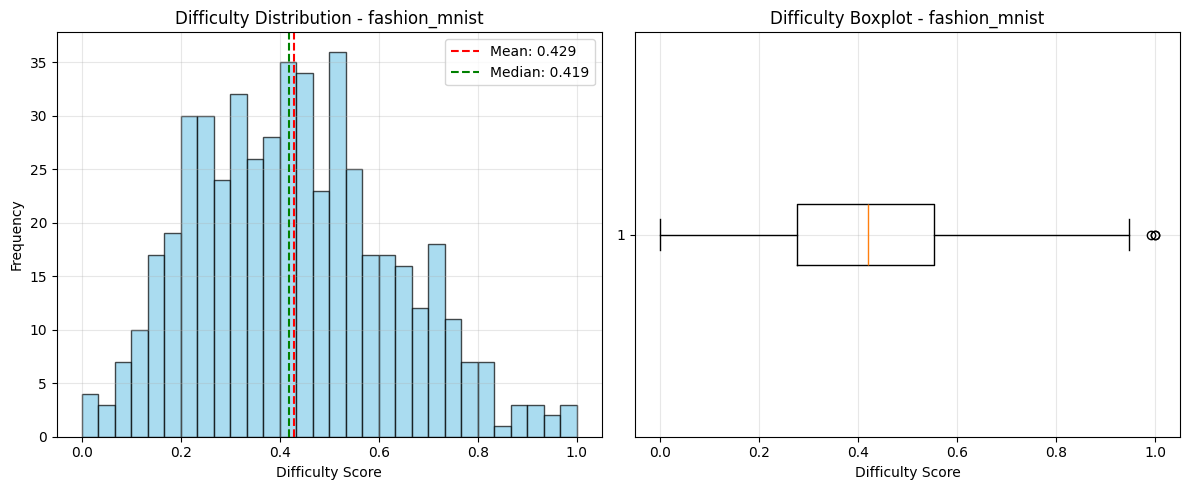

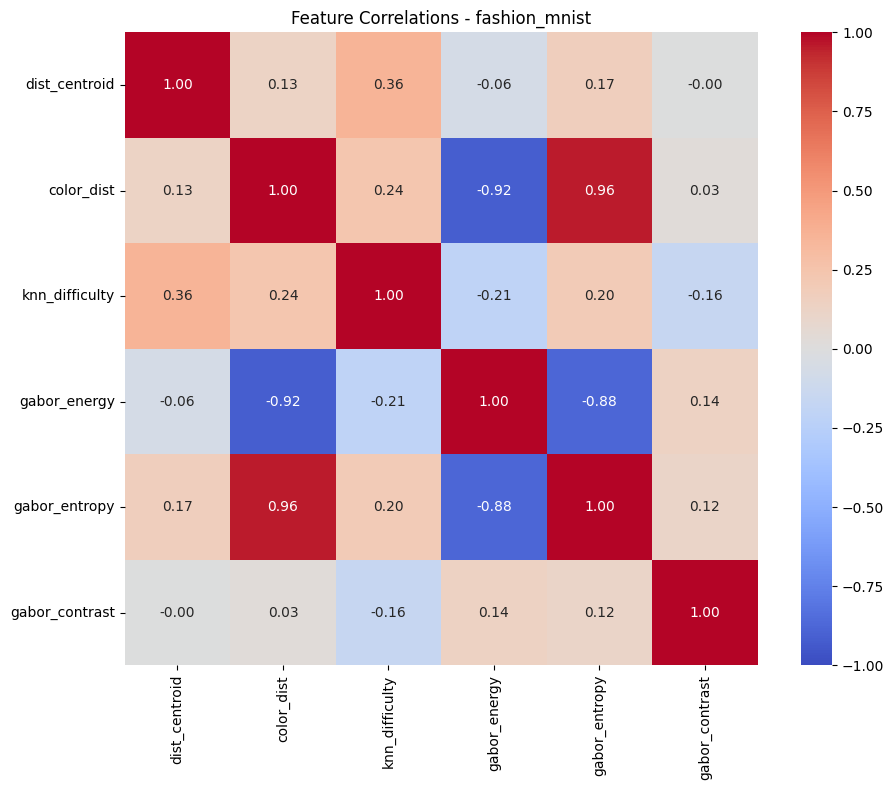

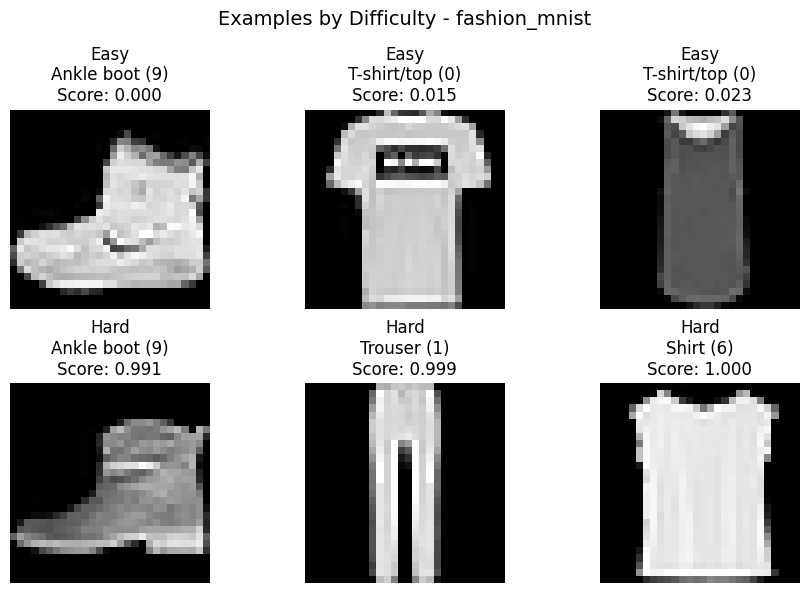

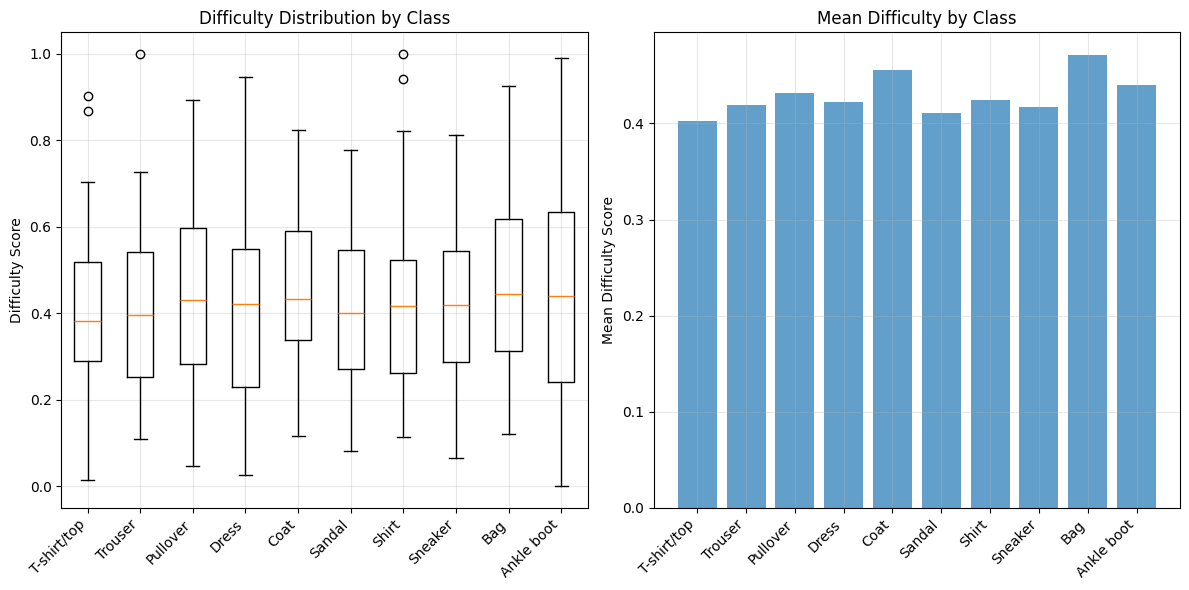


6. Statistics Report:
   - Dataset: fashion_mnist
   - Number of images: 500
   - Score range: 0.000 - 1.000
   - Mean score: 0.429 ± 0.198

7. Feature-score correlations:
   - dist_centroid: -0.029
   - color_dist: 0.013
   - knn_difficulty: 0.018
   - gabor_energy: 0.007
   - gabor_entropy: 0.021
   - gabor_contrast: -0.025

8. Saving curriculum orders...
   - Saved: curriculum_order_fashion_mnist_ascending.npy

PROCESS COMPLETED SUCCESSFULLY


Ejemplo 2: CIFAR-10
EXAMPLE: CURRICULUM LEARNING FOR CIFAR10

1. Loading dataset...


100%|██████████| 170M/170M [00:11<00:00, 15.3MB/s]


   - Images loaded: 1000
   - Format: (32, 32, 3)
   - Unique classes: 10

2. Initializing DifficultyScorer...
Scorer initialized for cifar10
  - Color mode: rgb
  - Use color HOG: True
  - DEevice: cuda

3. Precomputing features...
Computing features for 1000 imágenes...


Computing HOG:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing class's centroids...


Processing classes:   0%|          | 0/10 [00:00<?, ?it/s]

Computing KNN purity...


Computing features:   0%|          | 0/1000 [00:00<?, ?it/s]


4. Generating curriculum...
   - Generating with strategy: ascending

5. Generating visualizations...


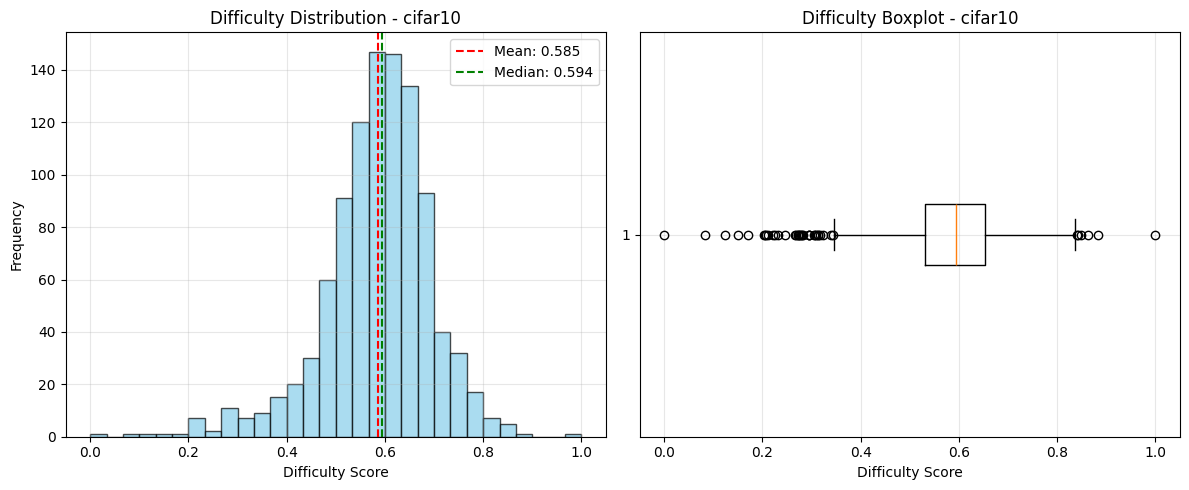

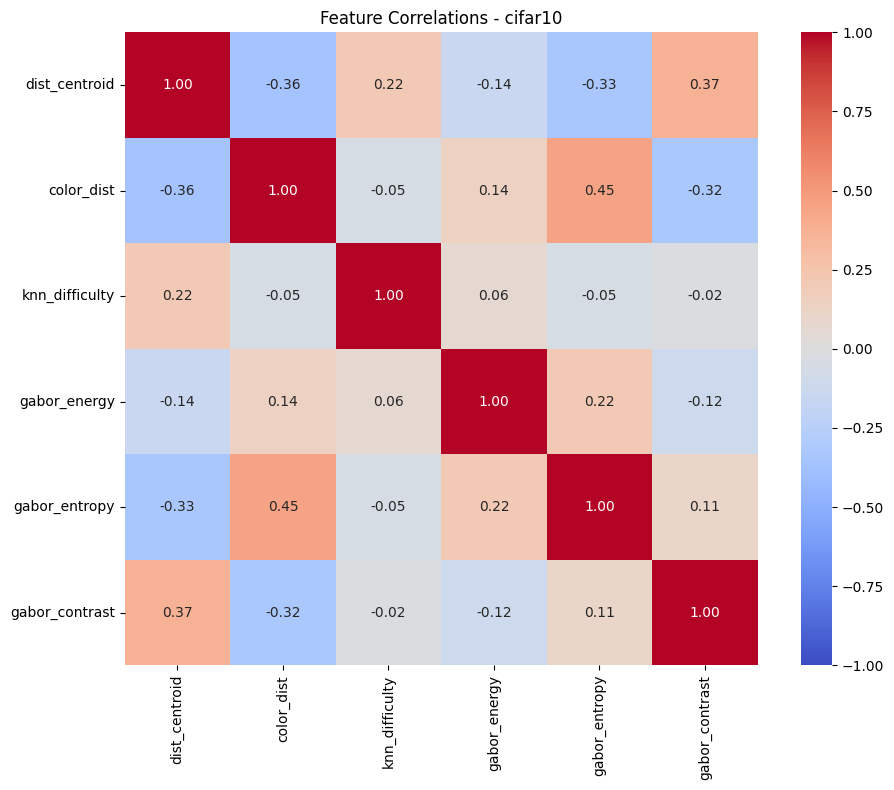

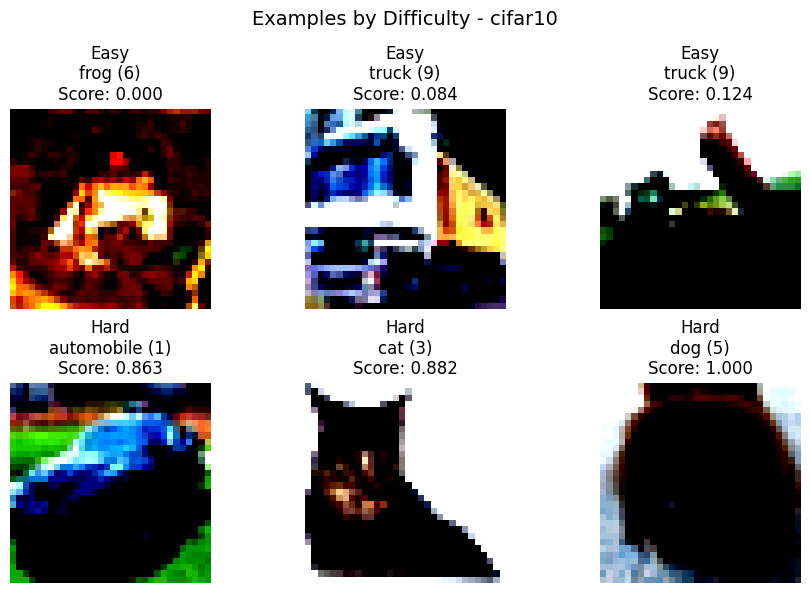

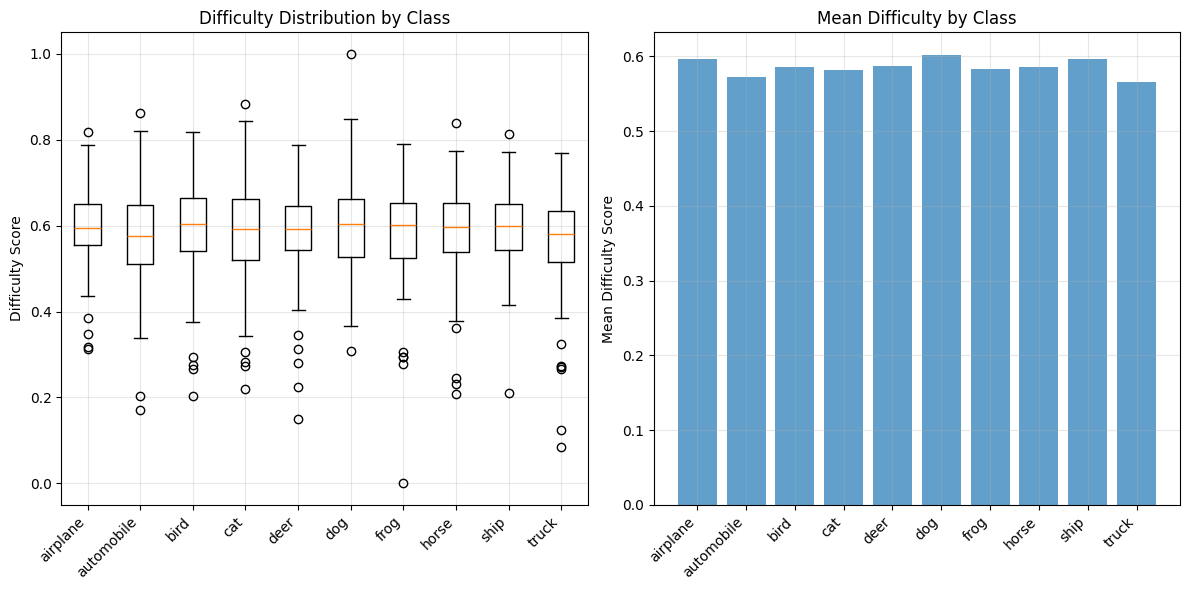


6. Statistics Report:
   - Dataset: cifar10
   - Number of images: 1000
   - Score range: 0.000 - 1.000
   - Mean score: 0.585 ± 0.110

7. Feature-score correlations:
   - dist_centroid: 0.051
   - color_dist: -0.035
   - knn_difficulty: 0.007
   - gabor_energy: -0.008
   - gabor_entropy: -0.028
   - gabor_contrast: 0.018

8. Saving curriculum orders...
   - Saved: curriculum_order_cifar10_ascending.npy

PROCESS COMPLETED SUCCESSFULLY


Ejemplo 3: CIFAR-100
EXAMPLE: CURRICULUM LEARNING FOR CIFAR100

1. Loading dataset...


100%|██████████| 169M/169M [00:10<00:00, 16.2MB/s]


   - Images loaded: 1000
   - Format: (32, 32, 3)
   - Unique classes: 100

2. Initializing DifficultyScorer...
Scorer initialized for cifar100
  - Color mode: rgb
  - Use color HOG: True
  - DEevice: cuda

3. Precomputing features...
Computing features for 1000 imágenes...


Computing HOG:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing class's centroids...


Processing classes:   0%|          | 0/100 [00:00<?, ?it/s]

Computing KNN purity...


Computing features:   0%|          | 0/1000 [00:00<?, ?it/s]


4. Generating curriculum...
   - Generating with strategy: ascending

5. Generating visualizations...


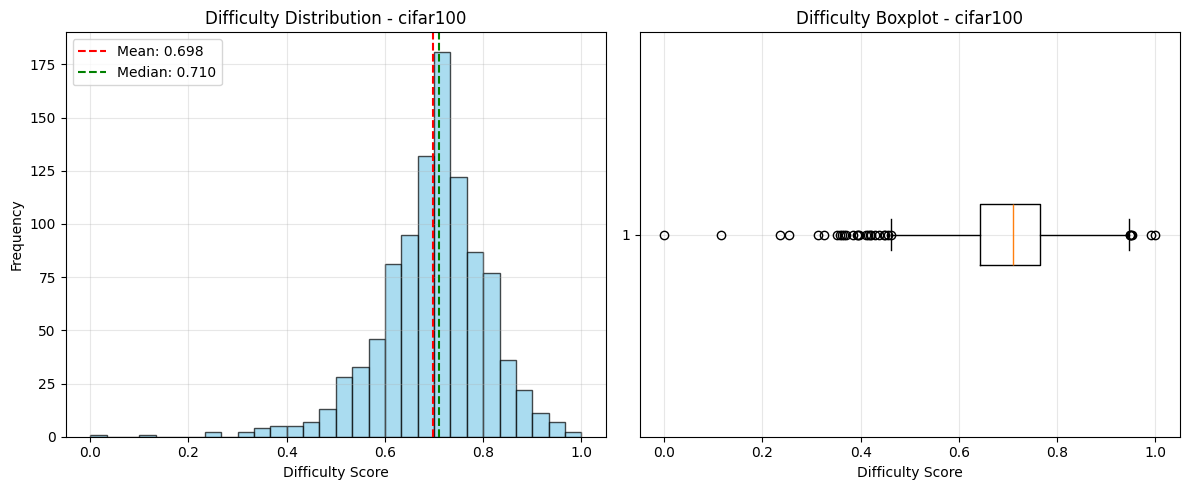

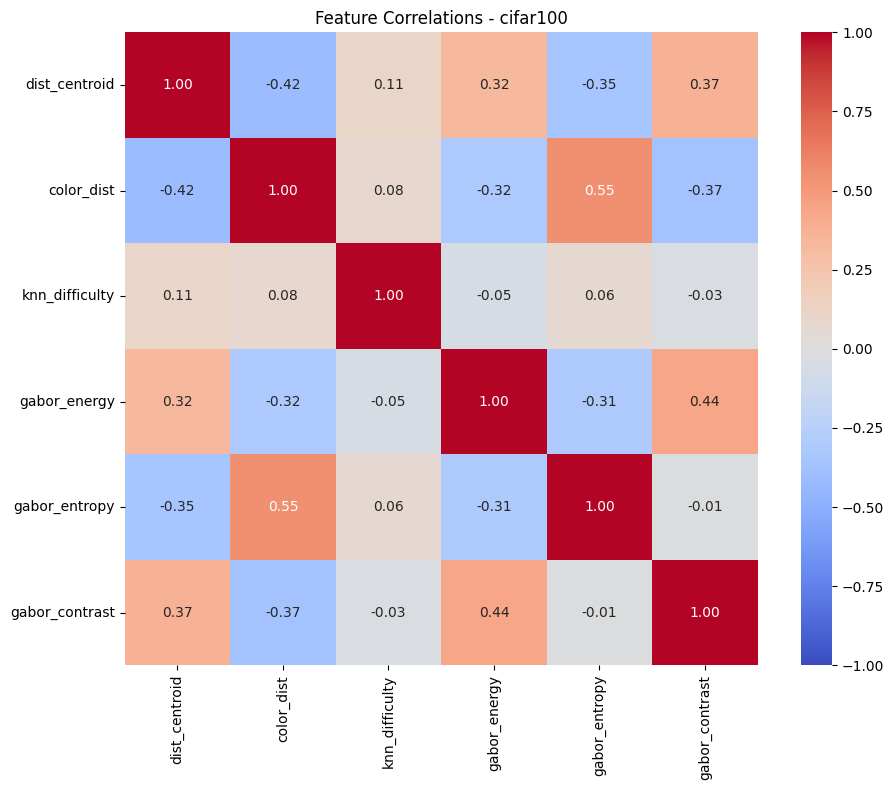

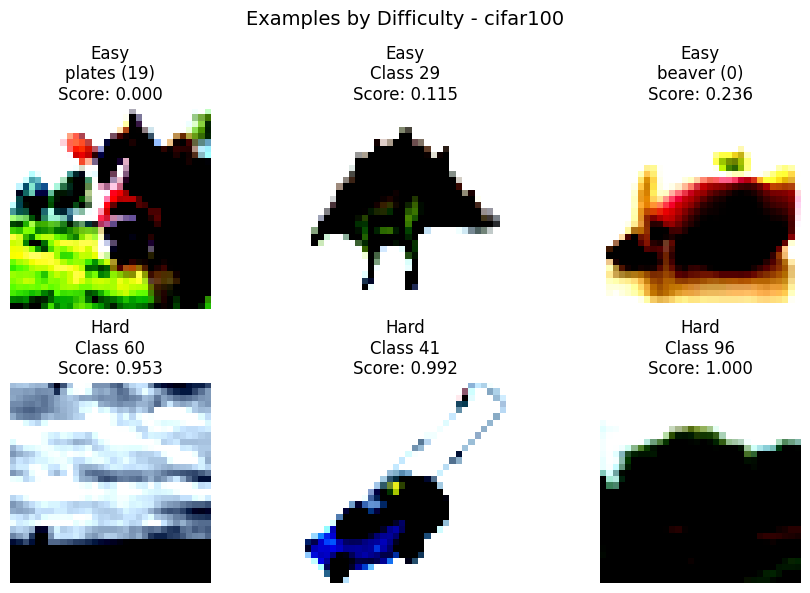

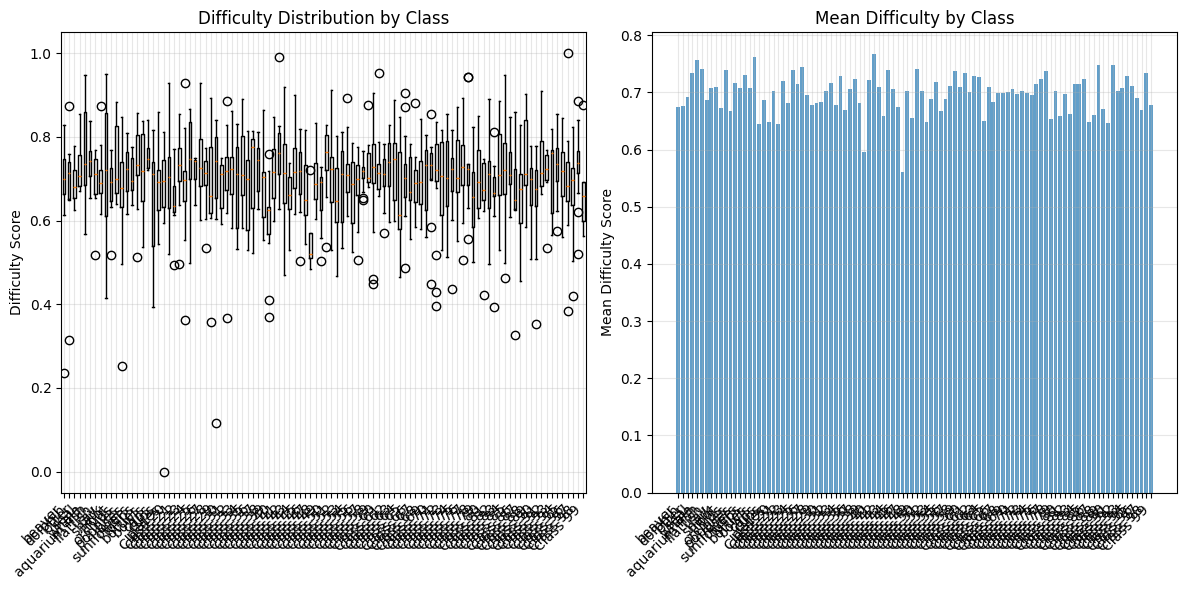


6. Statistics Report:
   - Dataset: cifar100
   - Number of images: 1000
   - Score range: 0.000 - 1.000
   - Mean score: 0.698 ± 0.108

7. Feature-score correlations:
   - dist_centroid: 0.061
   - color_dist: -0.016
   - knn_difficulty: -0.030
   - gabor_energy: 0.034
   - gabor_entropy: -0.041
   - gabor_contrast: -0.058

8. Saving curriculum orders...
   - Saved: curriculum_order_cifar100_ascending.npy

PROCESS COMPLETED SUCCESSFULLY


In [18]:
# Ejemplo 1: FashionMNIST (rápido)
print("Ejemplo 1: FashionMNIST")
results_fashion = run_full_example(
    dataset_name='fashion_mnist',
    n_samples=500,  # Reducido para rapidez
    use_color_hog=False
)

# Ejemplo 2: CIFAR-10
print("\n\nEjemplo 2: CIFAR-10")
results_cifar10 = run_full_example(
    dataset_name='cifar10',
    n_samples=1000,
    use_color_hog=True
)

# Ejemplo 3: CIFAR-100
print("\n\nEjemplo 3: CIFAR-100")
results_cifar100 = run_full_example(
    dataset_name='cifar100',
    n_samples=1000,
    use_color_hog=True
)